<a href="https://colab.research.google.com/github/AndiFt/DEEP-LEARNING_CLASSIFICATION-CAT-AND-DOG/blob/main/Salinan_dari_Klasifikasi_Kucing_dan_Anjing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/content/input"))

['train', 'test1', 'sampleSubmission.csv']


In [6]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [7]:
filenames = os.listdir("/content/input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
df.head()

filename  category
0  cat.12177.jpg         0
1   dog.4416.jpg         1
2   dog.3659.jpg         1
3   dog.1982.jpg         1
4   dog.6436.jpg         1

In [9]:
df.tail()

filename  category
24995  dog.10347.jpg         1
24996   cat.5127.jpg         0
24997    dog.149.jpg         1
24998   cat.3112.jpg         0
24999    dog.457.jpg         1

<Axes: >

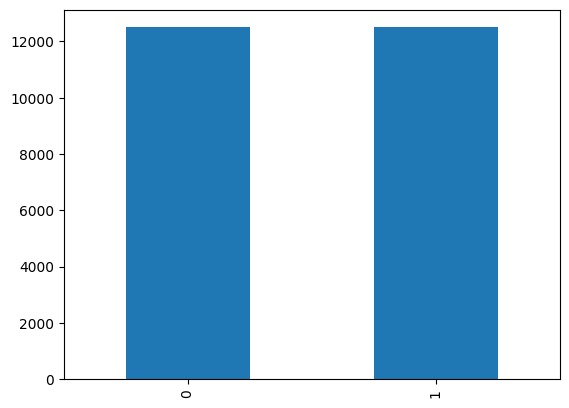

In [10]:
df['category'].value_counts().plot.bar()

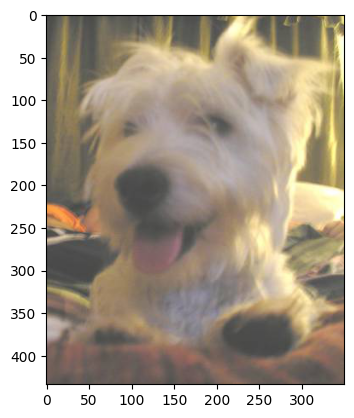

In [11]:
sample = random.choice(filenames)
image = load_img("/content/input/train/"+sample)
plt.imshow(image)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
earlystop = EarlyStopping(patience=10)

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
callbacks = [earlystop, learning_rate_reduction]

In [18]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [19]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

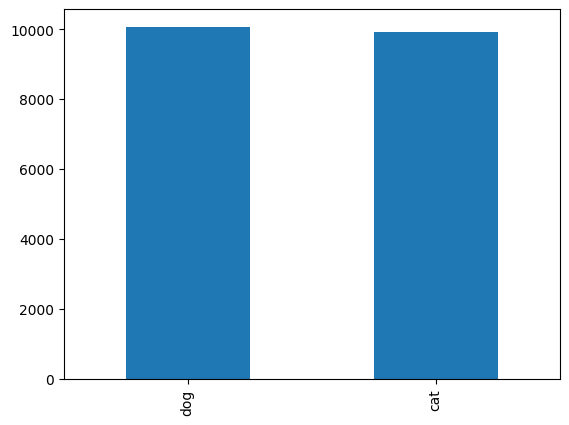

In [20]:
train_df['category'].value_counts().plot.bar()

<Axes: >

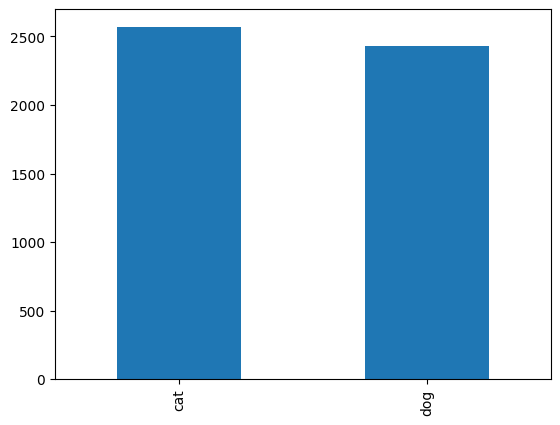

In [21]:
validate_df['category'].value_counts().plot.bar()

In [22]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [25]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


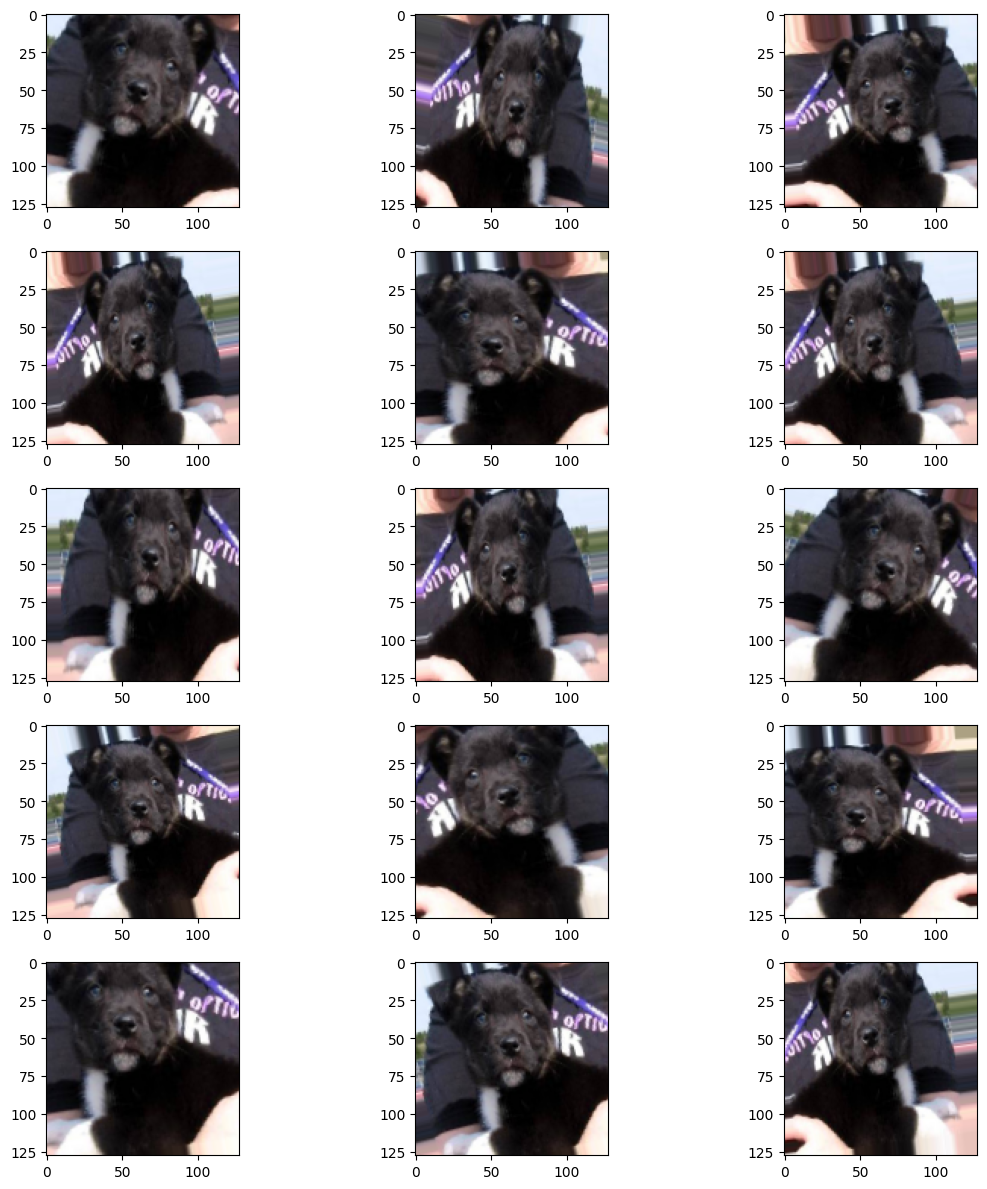

In [26]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [27]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


<ipython-input-27-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.6244

1333/1333 [==============================] - 175s 123ms/step - loss: 0.7487 - accuracy: 0.6244 - val_loss: 0.6990 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7125

1333/1333 [==============================] - 161s 120ms/step - loss: 0.5645 - accuracy: 0.7125 - val_loss: 0.4708 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.7578

1333/1333 [==============================] - 155s 116ms/step - loss: 0.5064 - accuracy: 0.7578 - val_loss: 0.4756 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.7797

1333/1333 [==============================] - 160s 120ms/step - loss: 0.4733 - accuracy: 0.7797 - val_loss: 0.4468 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.7933

1333/1333 [==============================] - 159s 120ms/step - loss: 0.4538 - accuracy: 0.7933 - val_loss: 0.3929 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8100

1333/1333 [==============================] - 161s 121ms/step - loss: 0.4256 - accuracy: 0.8100 - val_loss: 0.8747 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 7/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8188

1333/1333 [==============================] - 163s 122ms/step - loss: 0.4107 - accuracy: 0.8188 - val_loss: 0.3681 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 8/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8247

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3968 - accuracy: 0.8247 - val_loss: 0.3557 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 9/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8306

1333/1333 [==============================] - 154s 115ms/step - loss: 0.3823 - accuracy: 0.8306 - val_loss: 0.3744 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 10/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8353

1333/1333 [==============================] - 158s 119ms/step - loss: 0.3776 - accuracy: 0.8353 - val_loss: 0.4046 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 11/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8371

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3720 - accuracy: 0.8371 - val_loss: 2.8838 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 12/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8408

1333/1333 [==============================] - 159s 119ms/step - loss: 0.3627 - accuracy: 0.8408 - val_loss: 0.7138 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 13/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8456

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3574 - accuracy: 0.8456 - val_loss: 0.2660 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 14/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8547

1333/1333 [==============================] - 154s 116ms/step - loss: 0.3435 - accuracy: 0.8547 - val_loss: 0.4828 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 15/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8513

1333/1333 [==============================] - 159s 120ms/step - loss: 0.3449 - accuracy: 0.8513 - val_loss: 0.6260 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 16/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8576

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3366 - accuracy: 0.8576 - val_loss: 0.2571 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 17/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8542

1333/1333 [==============================] - 154s 115ms/step - loss: 0.3337 - accuracy: 0.8542 - val_loss: 0.3606 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 18/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8579

1333/1333 [==============================] - 155s 116ms/step - loss: 0.3296 - accuracy: 0.8579 - val_loss: 0.3093 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 19/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.8579

1333/1333 [==============================] - 159s 119ms/step - loss: 0.3298 - accuracy: 0.8579 - val_loss: 0.2703 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 20/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8637

1333/1333 [==============================] - 153s 115ms/step - loss: 0.3225 - accuracy: 0.8637 - val_loss: 0.2932 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 21/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8626

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3216 - accuracy: 0.8626 - val_loss: 0.4248 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 22/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8644

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3210 - accuracy: 0.8644 - val_loss: 0.2358 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 23/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8660

1333/1333 [==============================] - 153s 115ms/step - loss: 0.3145 - accuracy: 0.8660 - val_loss: 0.5188 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 24/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8695

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3097 - accuracy: 0.8695 - val_loss: 0.3823 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 25/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8720

1333/1333 [==============================] - 160s 120ms/step - loss: 0.3101 - accuracy: 0.8720 - val_loss: 0.2463 - val_accuracy: 0.9053 - lr: 0.0010
Epoch 26/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8716

1333/1333 [==============================] - 158s 119ms/step - loss: 0.3042 - accuracy: 0.8716 - val_loss: 0.3425 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 27/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8772

1333/1333 [==============================] - 160s 120ms/step - loss: 0.2993 - accuracy: 0.8772 - val_loss: 0.2327 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 28/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.8733

1333/1333 [==============================] - 154s 115ms/step - loss: 0.2988 - accuracy: 0.8733 - val_loss: 2.4653 - val_accuracy: 0.6589 - lr: 0.0010
Epoch 29/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8735

1333/1333 [==============================] - 153s 115ms/step - loss: 0.3036 - accuracy: 0.8735 - val_loss: 0.3254 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 30/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8745

1333/1333 [==============================] - 161s 121ms/step - loss: 0.2976 - accuracy: 0.8745 - val_loss: 0.2504 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 31/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8784

1333/1333 [==============================] - 153s 115ms/step - loss: 0.2916 - accuracy: 0.8784 - val_loss: 0.4410 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 32/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2929 - accuracy: 0.8749

1333/1333 [==============================] - 159s 120ms/step - loss: 0.2929 - accuracy: 0.8749 - val_loss: 0.2492 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 33/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8773

1333/1333 [==============================] - 160s 120ms/step - loss: 0.2950 - accuracy: 0.8773 - val_loss: 0.2777 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 34/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.8772

1333/1333 [==============================] - 163s 123ms/step - loss: 0.2879 - accuracy: 0.8772 - val_loss: 0.5363 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 35/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8835

1333/1333 [==============================] - 162s 122ms/step - loss: 0.2802 - accuracy: 0.8835 - val_loss: 0.2105 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 36/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8848

1333/1333 [==============================] - 154s 115ms/step - loss: 0.2824 - accuracy: 0.8848 - val_loss: 0.2305 - val_accuracy: 0.9109 - lr: 0.0010
Epoch 37/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8843

1333/1333 [==============================] - 158s 119ms/step - loss: 0.2824 - accuracy: 0.8843 - val_loss: 0.1953 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 38/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8827

1333/1333 [==============================] - 159s 120ms/step - loss: 0.2820 - accuracy: 0.8827 - val_loss: 0.2573 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 39/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8846

1333/1333 [==============================] - 159s 120ms/step - loss: 0.2800 - accuracy: 0.8846 - val_loss: 0.2238 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 40/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.8879

1333/1333 [==============================] - 153s 115ms/step - loss: 0.2689 - accuracy: 0.8879 - val_loss: 0.1897 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 41/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.8821

1333/1333 [==============================] - 160s 120ms/step - loss: 0.2822 - accuracy: 0.8821 - val_loss: 0.2277 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 42/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8870

1333/1333 [==============================] - 161s 120ms/step - loss: 0.2736 - accuracy: 0.8870 - val_loss: 0.2362 - val_accuracy: 0.9047 - lr: 0.0010
Epoch 43/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8881

1333/1333 [==============================] - 159s 119ms/step - loss: 0.2736 - accuracy: 0.8881 - val_loss: 0.2276 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 44/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8871

1333/1333 [==============================] - 158s 118ms/step - loss: 0.2759 - accuracy: 0.8871 - val_loss: 0.2426 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 45/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2689 - accuracy: 0.8864

1333/1333 [==============================] - 153s 115ms/step - loss: 0.2689 - accuracy: 0.8864 - val_loss: 0.3764 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 46/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.8877

1333/1333 [==============================] - 153s 115ms/step - loss: 0.2656 - accuracy: 0.8877 - val_loss: 0.2147 - val_accuracy: 0.9185 - lr: 0.0010
Epoch 47/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.8904

1333/1333 [==============================] - 163s 122ms/step - loss: 0.2655 - accuracy: 0.8904 - val_loss: 0.2143 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 48/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.8917

1333/1333 [==============================] - 153s 115ms/step - loss: 0.2660 - accuracy: 0.8917 - val_loss: 0.2598 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 49/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.8922

1333/1333 [==============================] - 159s 119ms/step - loss: 0.2642 - accuracy: 0.8922 - val_loss: 0.2466 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 50/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.8906

1333/1333 [==============================] - 161s 121ms/step - loss: 0.2641 - accuracy: 0.8906 - val_loss: 0.3192 - val_accuracy: 0.8811 - lr: 0.0010


In [28]:
model.save_weights("model.h5")

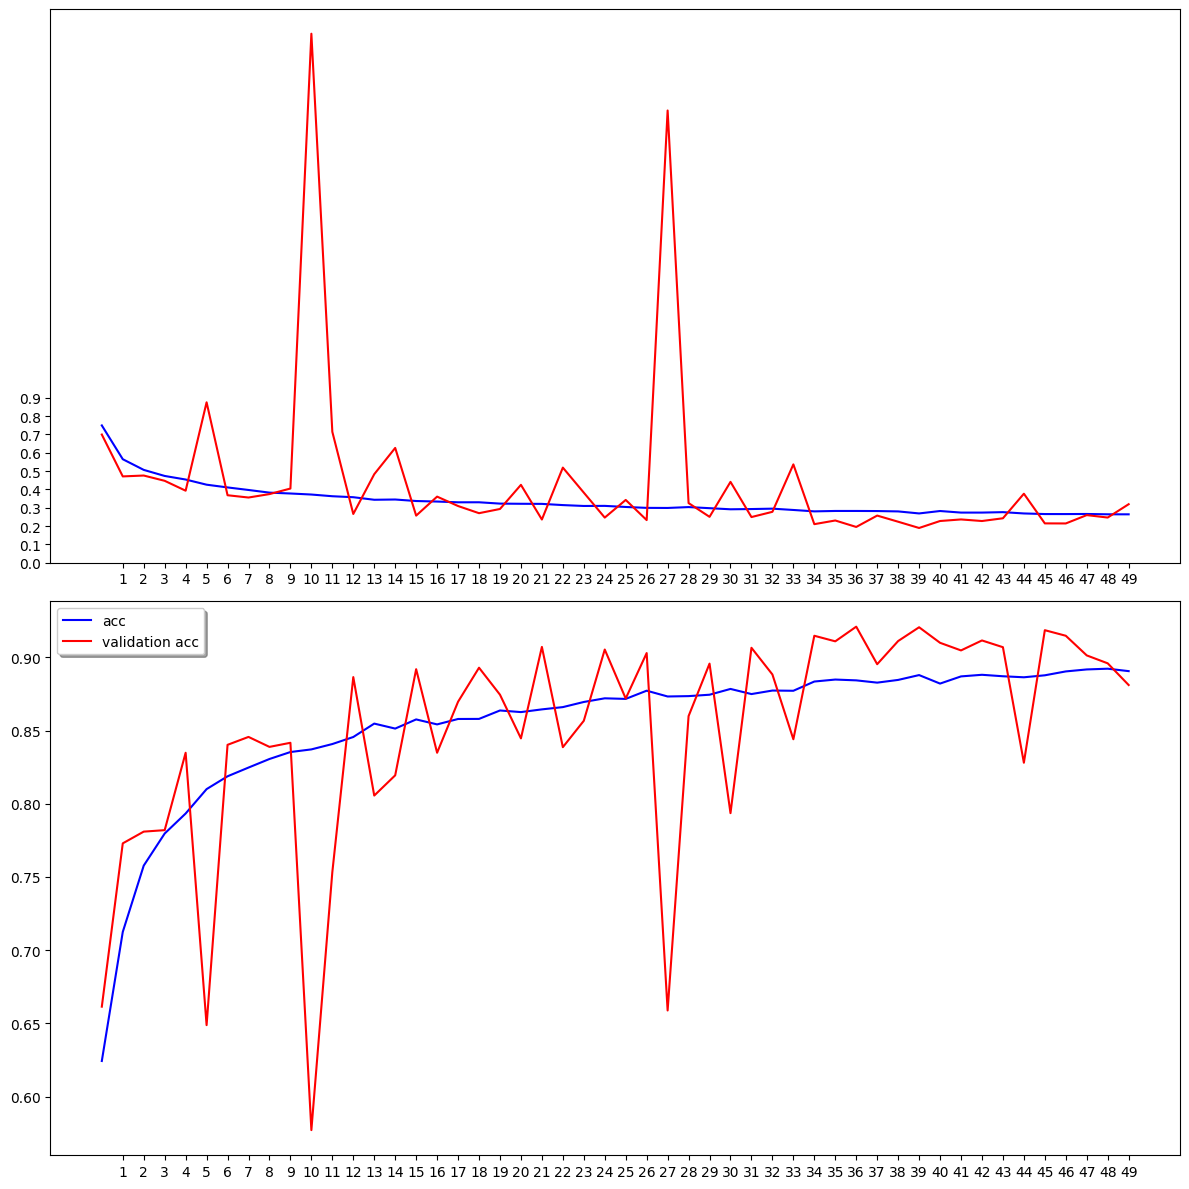

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="acc")
ax2.plot(history.history['val_accuracy'], color='r',label="validation acc")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [37]:
test_filenames = os.listdir("/content/input/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [38]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/input/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [39]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-39-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [40]:
test_df['category'] = np.argmax(predict, axis=-1)

In [41]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [42]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<Axes: >

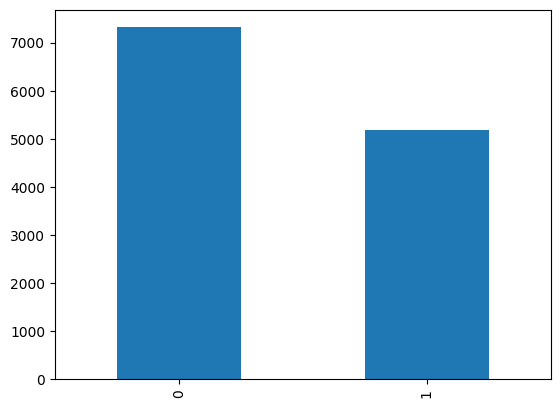

In [43]:
test_df['category'].value_counts().plot.bar()

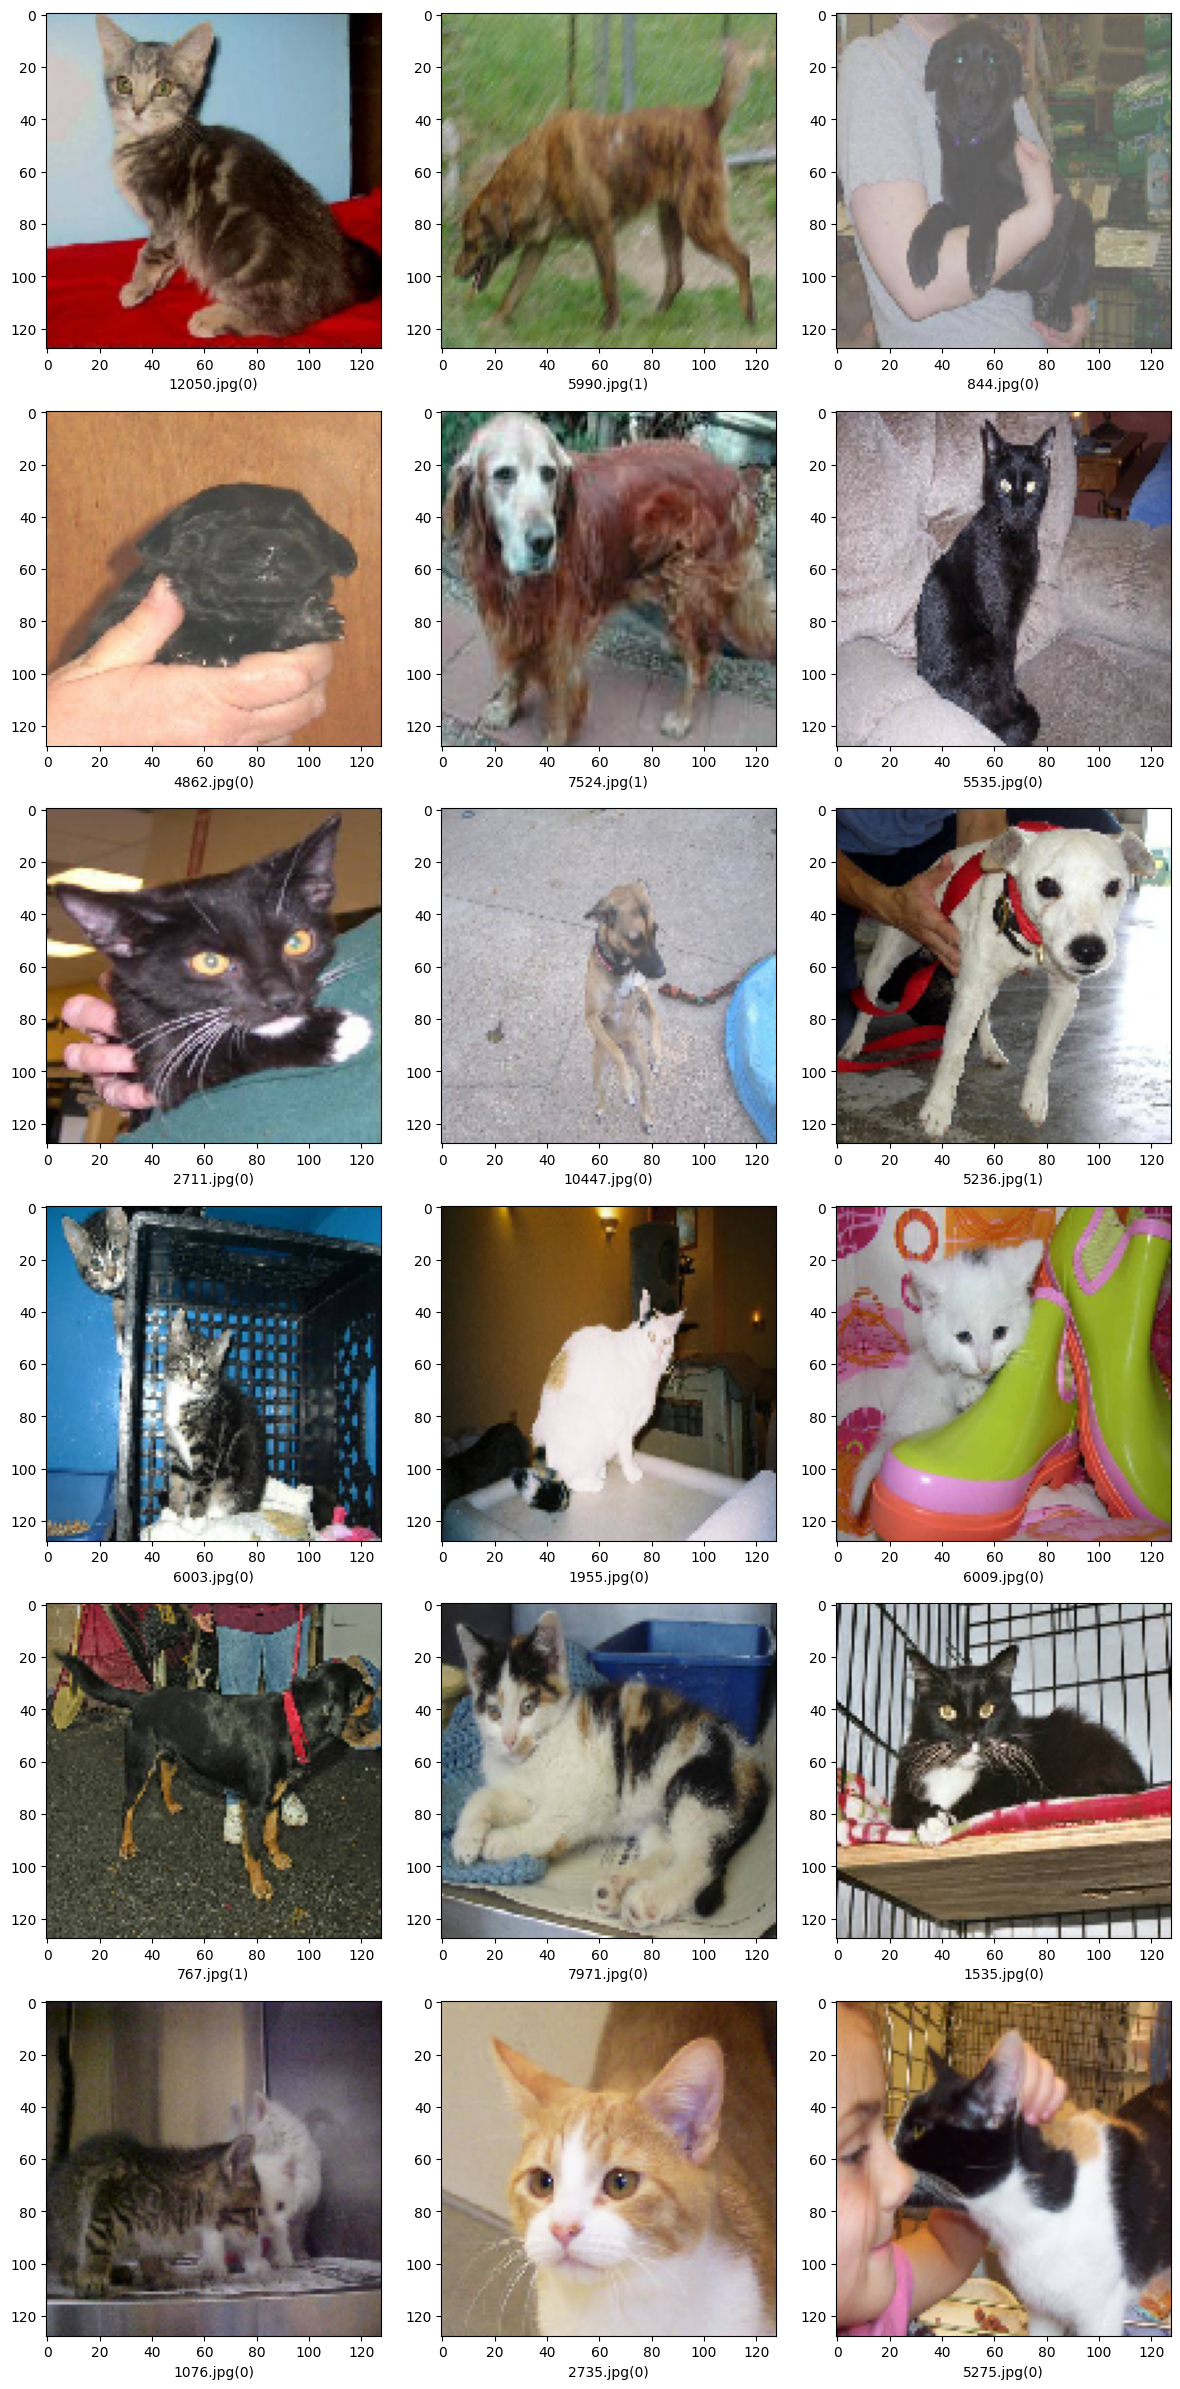

In [45]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [46]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)